In [551]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import datetime
import os
import sys
import pickle
from scipy.linalg import logm

In [552]:
from discopro.grammar import tensor
from discopro.anaphora import connect_anaphora_on_top, connect_anaphora
from lambeq import BobcatParser, NumpyModel, AtomicType, Rewriter, Dataset, QuantumTrainer, SPSAOptimizer , AtomicType, IQPAnsatz, RemoveCupsRewriter, UnifyCodomainRewriter, BinaryCrossEntropyLoss
from lambeq.backend.grammar import Spider, Ty
from lambeq.backend.quantum import Box, qubit, SelfConjugate, Ry, Diagram
from contextuality.model import Model, Scenario, CyclicScenario

In [596]:
models = {'disjoint_uncut': 'runs/disjoint_uncut_130E/best_model.lt', 
          'disjoint_cut': 'runs/disjoint_cut_140E/best_model.lt',
          'spider_uncut': 'runs/spider_uncut_200E/best_model.lt', 
          'spider_cut': 'runs/spider_cut_60E/best_model.lt'}

diagrams = {'disjoint_uncut': 'dataset/diagrams/disjoint_uncut.pkl',
            'disjoint_cut': 'dataset/diagrams/disjoint_cut.pkl',
            'spider_uncut': 'dataset/diagrams/spider_uncut.pkl',
            'spider_cut': 'dataset/diagrams/spider_cut.pkl'}

data = {'disjoint_uncut': 'dataset/contextuality_data/scenario442_disjoint_uncut.csv',
        'disjoint_cut': 'dataset/contextuality_data/scenario442_disjoint_cut.csv',
        'spider_uncut': 'dataset/contextuality_data/scenario422_spider_uncut.csv',
        'spider_cut': 'dataset/contextuality_data/scenario442_spider_cut.csv'}

In [554]:
remove_cups = RemoveCupsRewriter()

parser = BobcatParser()
rewriter = Rewriter(['auxiliary',
                     'connector',
                     'coordination',
                     'determiner',
                     'object_rel_pronoun',
                     'subject_rel_pronoun',
                     'postadverb',
                     'preadverb',
                     'prepositional_phrase'])

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE 

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [555]:
def sent2dig(sentence1: str, sentence2: str, pro: str, ref: str, mode='default', con=True):
    diagram1 = parser.sentence2diagram(sentence1)
    diagram2 = parser.sentence2diagram(sentence2)
    diagram = tensor(diagram1, diagram2)
    
    if mode == 'spider':
        diagram = diagram >> Spider(S, 2, 1)
    elif mode == 'box':
        merger = UnifyCodomainRewriter(S)
        diagram = merger(diagram)

    if con == True:
        pro_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == pro.casefold())
        ref_box_idx = next(i for i, box in enumerate(diagram.boxes) if box.name.casefold() == ref.casefold())
        diagram = connect_anaphora(diagram, pro_box_idx, ref_box_idx)
        
    diagram = rewriter(remove_cups(diagram)).normal_form()
    return diagram

In [677]:
class data_processor:
    def __init__(self, scenario: Scenario, model_path: str=None):
        self.scenario = scenario # Measurement scenario modelling the schema

        # Data
        self.data = pd.DataFrame(columns=["Sentence", "CF", "SF", "CbD", "DI", "Violation", "Distribution"])
        self.diagrams = []
        self.sentences = []
            
        if model_path: # Model is a NumpyModel with learnt parameters of ansatz circuits
            self.model = NumpyModel.from_checkpoint(model_path)
            self.model.initialise_weights()
        else:
            self.model = None

        # Measurement basis used in max violation CHSH experiment with their matrix representations
        self.bases = {'a':Ry(0), 'A':Ry(np.pi/4), 'b':Ry(np.pi/8), 'B':Ry(3*np.pi/8)}
        self.pairs = {'ab': np.kron(Ry(0).array, Ry(np.pi/8).array),
                      'aB': np.kron(Ry(0).array, Ry(3*np.pi/8).array),
                      'Ab': np.kron(Ry(np.pi/4).array, Ry(np.pi/8).array),
                      'AB': np.kron(Ry(np.pi/4).array, Ry(3*np.pi/8).array)}

    def load_file(self, path: str) -> None | pd.DataFrame | zip:
        if not path:
            return
        elif os.path.splitext(path)[-1] == '.csv':
            return pd.read_csv(path)
        elif os.path.splitext(path)[-1] == '.pkl':
            file = open(path, 'rb')
            data =  pickle.load(file)
            file.close()
            return data
        else:
            print("Provided file doesn't match a supported type.")
            return

    def load_model(self, path: str, variant: str=None) -> None:
        self.model = NumpyModel.from_checkpoint(model_path)

    def get_data(self, path: str) -> None:
        if not path:
            return
        self.data = self.load_file(path)

    def get_diagrams(self, path: str, con=True) -> None:
        if not path:
            return
        
        schema_data = self.load_file(path)
        if os.path.splitext(path)[-1] == '.pkl':
            self.sentences, self.diagrams = zip(*schema_data)
            self.sentences = list(self.sentences)
            self.diagrams = list(self.diagrams)
            return
            
        for _, row in tqdm(schema_data.iterrows(), total=len(schema_data)):
            try:
                s1, s2, pro, ref = row[['sentence1','sentence2','pronoun','referent']]
                self.diagrams.append(ansatz(sent2dig(s1, s2, pro, ref, con=con)))
                self.sentences.append(s1 + '. ' + s2 + '.')
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        f = open('dataset/sent_circ_pairs'+'_'+str(len(self.diagrams))+'_'+datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")+'.pkl', 'wb')
        pickle.dump(list(zip(self.sentences, self.diagrams)), f)
        f.close()

    def get_emp_model(self, diag: Diagram) -> Model:
        diag_ab = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['b'],1)
        diag_aB = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['B'],1)
        diag_Ab = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['b'],1)
        diag_AB = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['B'],1)

        pr_dist = self.model.get_diagram_output([diag_ab, diag_aB, diag_Ab, diag_AB])
        pr_dist = np.reshape(pr_dist, (4,4))
        return Model(self.scenario, pr_dist)

    def calc_violation(self, pr_dist: np.array) -> float:
        state = np.sqrt(pr_dist)
        expectations = [np.matmul(state, np.matmul(self.pairs[ops], state)) for ops in list(self.pairs.keys())]
        res = 0
        for i in range(4):
            cur = abs(sum(expectations) - 2*expectations[i])
            #possible_vals.append(res)
            res = max(res, cur)
        return res

    def bipartide_partial_trace(self, state):
        dense_mat = np.outer(state, state)
        n_dim = len(state)//2
        id_mat = np.identity(n_dim)
        basis = np.split(id_mat, n_dim)
    
        res = np.zeros((n_dim, n_dim))
        for vec in basis:
            bra = np.kron(id_mat,vec)
            ket = np.kron(id_mat, vec).T
            res += np.matmul(np.matmul(bra, dense_mat), ket)
        return res

    def calc_vne(self, dense_mat):
        evals = np.linalg.eigvalsh(dense_mat)
        filtered_evals = evals[np.abs(evals) > 1e-12]
        ent = -np.sum(filtered_evals * np.log(filtered_evals))
        if ent > 1e-12:
            return ent
        else:
            return 0

    def gen_data(self) -> None:
        data_dict = {'Sentence':[], 'CF':[], 'SF':[], 'CbD':[], 'DI':[], 'Violation':[], 'Distribution': []}
        for diagram, sentence in tqdm(zip(self.diagrams, self.sentences), total=len(self.diagrams)):
            try:
                cur_emp_model = self.get_emp_model(diagram)
                
                data_dict['CF'].append(cur_emp_model.signalling_fraction())
                data_dict['SF'].append(cur_emp_model.contextual_fraction())
                data_dict['CbD'].append(cur_emp_model.CbD_measure())
                data_dict['DI'].append(cur_emp_model.CbD_direct_influence())
                data_dict['Distribution'].append(cur_emp_model._distributions)
                state = self.model.get_diagram_output([diagram])[0].flatten()
                data_dict['Violation'].append(self.calc_violation(state))
                data_dict['Sentence'].append(sentence)
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        self.data = pd.DataFrame(data_dict)
        self.data.to_csv('dataset/scenario442_' + str(len(self.diagrams)) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S") + '.csv')

    def plot_cnxt(self, title: str, save: bool=True) -> None:
        cf = self.data['CF'].to_numpy()
        sf = self.data['SF'].to_numpy()
        di = self.data['DI'].to_numpy()
        cmap = plt.get_cmap('viridis_r')
        cmap.set_under('red')
        scat = plt.scatter(x=cf, y=di, c=sf, cmap=cmap, vmax=1, vmin=1/6)
        plt.axvline(x=1/6, color='r', linestyle='-')
        plt.axhline(y=2, color='r', linestyle='-')
        plt.text(x=1/6+0.05,y=5,s='Sheaf Contextual')
        plt.text(x=0.7,y=1.5,s='CbD Contextual')
        plt.xlabel('Contextual Fraction')
        plt.ylabel('Direct Influence')
        plt.colorbar(label='Signalling Fraction', extend='min')
        plt.title(title)
        scat.set_alpha(0.5)
        scat.cmap.set_over('red')
        if save:
            plt.savefig('figures/' + title + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
        plt.show()

    def test_plot(self, title: str, save: bool=True, x=[], y=[], z=[], vmin=0, vmax=0,
                 x_label='x', y_label='y', z_label='z') -> None:
        if vmax==0:
            vmax=max(z)

        cmap = plt.get_cmap('viridis')
        cmap.set_under('red')
        scat = plt.scatter(x=x, y=y, c=z, alpha=1, vmax=vmax, vmin=vmin, cmap=cmap)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.colorbar(label=z_label, extend='min')
        plt.title(title)
        scat.set_alpha(0.5)
        scat.cmap.set_under('red')
        plt.show()

In [606]:
scenario_442_skip = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                     model_path=models['spider_cut'])

In [607]:
scenario_442_skip.get_data(data['spider_cut'])

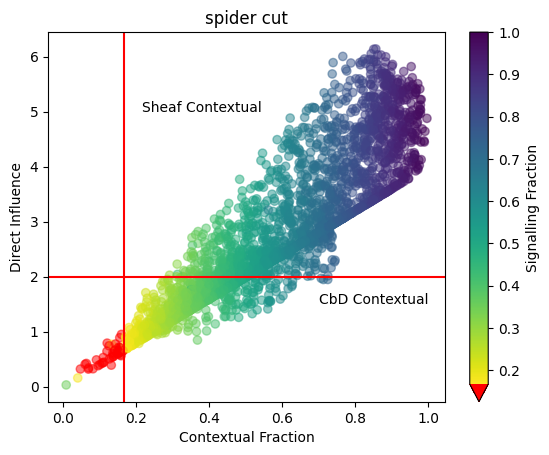

In [608]:
scenario_442_skip.plot_cnxt(title="spider cut", save=True)

In [611]:
scenario_442_spider = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                     model_path=models['spider_uncut'])

In [612]:
scenario_442_spider.get_data(data['spider_uncut'])

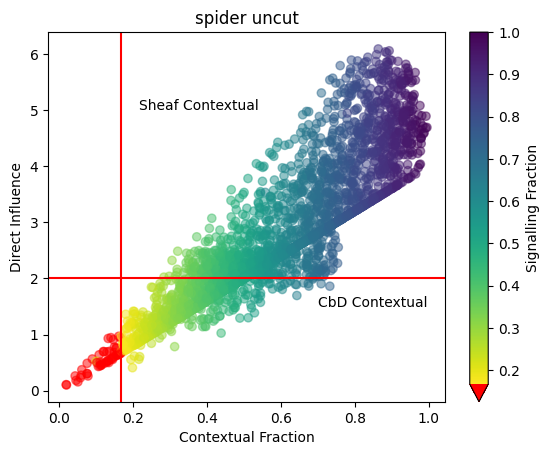

In [613]:
scenario_442_spider.plot_cnxt(title="spider uncut", save=True)

In [615]:
scenario_442_disjoint = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                                       model_path=models['disjoint_uncut'])

In [616]:
scenario_442_disjoint.get_data(data['disjoint_uncut'])

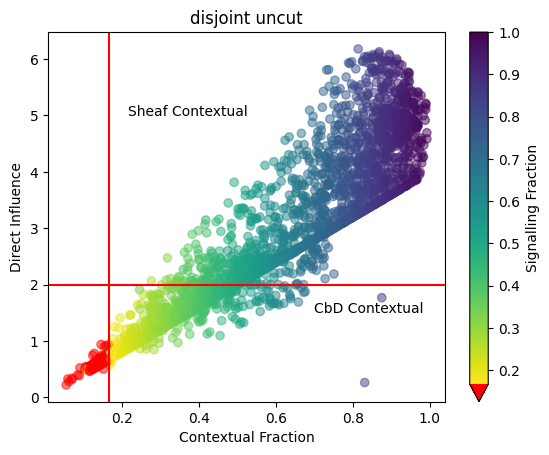

In [617]:
scenario_442_disjoint.plot_cnxt(title="disjoint uncut", save=True)

In [624]:
scenario_442_disjoint_cut = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                                           model_path=models['disjoint_cut'])

In [625]:
scenario_442_disjoint_cut.get_data('dataset/contextuality_data/scenario442_disjoint_cut.csv')

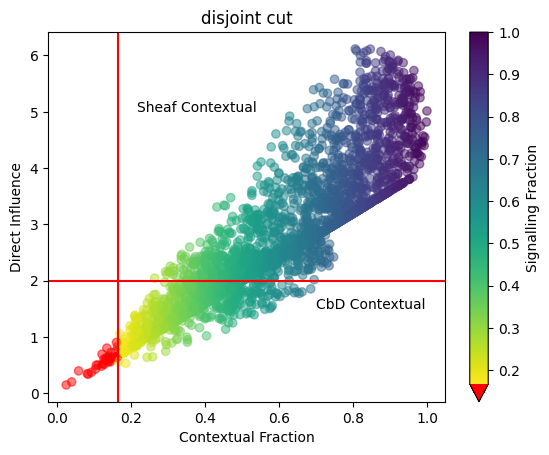

In [626]:
scenario_442_disjoint_cut.plot_cnxt(title="disjoint cut")

In [678]:
test = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                      model_path=models['spider_uncut'])

In [679]:
test.get_data(data['spider_uncut'])
test.get_diagrams(diagrams['spider_uncut'])

In [680]:
x = test.data["CF"]
z = test.data["SF"]

In [673]:
y = []
for diagram in test.diagrams:
    try:
        dist = test.model.get_diagram_output([diagram])[0].flatten()
        reduced_dense_mat = test.bipartide_partial_trace(np.sqrt(dist))
        y.append(test.calc_vne(reduced_dense_mat))
    except:
        pass

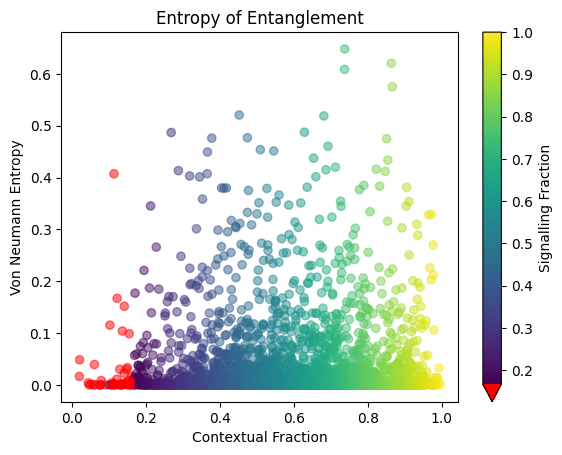

In [681]:
test.test_plot(title="Entropy of Entanglement", save=True, x=x, y=y, z=z, vmin=1/6, vmax=1,
                                    x_label='Contextual Fraction', y_label='Von Neumann Entropy', z_label='Signalling Fraction')